In [1]:
import open3d as o3d
import numpy as np
import os, sys, time, yaml
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
from scipy import stats

from collections import deque
from numpy.linalg import inv
import pickle
from functools import partial

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


`pipenv run python -m snakeviz program.prof`

`pipenv run python -m cProfile -o program.prof map_creators2.py`

In [2]:
from utils.one import *
from utils.two import *

In [3]:
dataset = '/home/alex_odnakov/personal/dataset'
sequences_dir = os.path.join(dataset, "sequences")
sequence_folders = [
    f for f in sorted(os.listdir(sequences_dir))
    if os.path.isdir(os.path.join(sequences_dir, f))
]

seq_i=8
i=0
scan_list = {}
labels_list = {}
for i in sequence_folders:
    scan_list[i] = sorted(os.listdir(os.path.join(sequences_dir,i,'velodyne')))
    if os.path.isdir(os.path.join(sequences_dir,i,'labels')):
        labels_list[i] = sorted(os.listdir(os.path.join(sequences_dir,i,'labels')))
i = 0


one_pc = SemLaserScan(color_dict,H=64*3, W=1024*3, project=True)

one_pc.open_scan(os.path.join(sequences_dir,sequence_folders[seq_i],'velodyne',scan_list[sequence_folders[seq_i]][i]))
one_pc.open_label(os.path.join(sequences_dir,sequence_folders[seq_i],'labels',labels_list[sequence_folders[seq_i]][i]))
one_pc.colorize()
# a.show()
# one_pc.proj_range.max(),one_pc.proj_range[one_pc.proj_range>0].min()

# one_pc = show_one_scan(one_pc, poses, 0)

In [4]:

calibration = parse_calibration(os.path.join(sequences_dir,sequence_folders[seq_i], "calib.txt"))
poses = parse_poses(os.path.join(sequences_dir,sequence_folders[seq_i], "poses.txt"), calibration)
poses = np.hstack(poses)
# diffs = []
# for post in posses:
#     diff = np.matmul(inv(pose), past["pose"])

In [5]:
def load_kitti_scan(file_path):
    scan = np.fromfile(file_path, dtype=np.float32)
    return scan.reshape((-1, 4))

def transform_cloud_to_world_frame(xyz, pose):
    points = np.hstack((xyz, np.ones((xyz.shape[0], 1), dtype=xyz.dtype)))
    transformed_points = pose @ points.T
    return transformed_points.T[:,:3]
    
def transform_cloud_to_origin_frame(xyz, pose):
    points = np.hstack((xyz, np.ones((xyz.shape[0], 1), dtype=xyz.dtype)))
    transformed_points = np.linalg.inv(pose) @ points.T
    return transformed_points.T[:,:3]

def create_birds_eye_view(points, labels, voxel_size, side_range=(-100, 100), fwd_range=(-100, 100)):
    mask = (
        (points[:, 0] >= fwd_range[0]) & (points[:, 0] < fwd_range[1]) &
        (points[:, 1] >= side_range[0]) & (points[:, 1] < side_range[1])
    )
    points = points[mask]
    labels = labels[mask]
    bev_image = np.zeros((  int((fwd_range[1] - fwd_range[0]) / voxel_size)
                          * int((side_range[1] - side_range[0]) / voxel_size)
                          , 3))
    # print(labels.shape)
    indices = np.floor((points[:, [0, 1]] - [fwd_range[0], side_range[0]]) / voxel_size).astype(np.int32)
    
    indices_1d = indices[:, 0] * int((side_range[1] - side_range[0]) / voxel_size) + indices[:, 1]
    # print(indices.shape, indices_1d.max(),bev_image[indices_1d].shape)
    # return indices_1d
    bev_image[indices_1d] += labels
    # return indices_1d, indices
    bev_image = bev_image.reshape((int((fwd_range[1] - fwd_range[0]) / voxel_size)
                                , -1
                                , 3)
    )
    # bev_image.ravel()[indices_1d] = 1  # Increase count in the cell where the point falls

    return bev_image
# plt.figure(figsize=(20,20))
# plt.imshow(create_birds_eye_view(a.points, a.sem_label_color,0.05, side_range=(-50, 150), fwd_range=(-30, 70)))
# plt.savefig('aa.png')
# create_birds_eye_view(one_pc.points, one_pc.sem_label_color,0.3)

In [12]:
labels_list[sequence_folders[seq_i]][0]

'000000.label'

In [133]:
img_list2 = []

matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


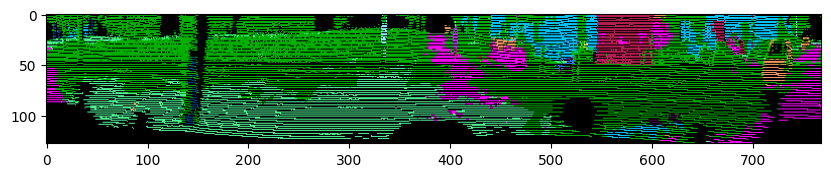

In [140]:
two_pc = SemLaserScan(color_dict,H=128, W=128*6, project=True)

two_pc.open_scan(os.path.join(sequences_dir,sequence_folders[seq_i],'velodyne',scan_list[sequence_folders[seq_i]][200]))
# two_pc.open_label(os.path.join(sequences_dir,sequence_folders[seq_i],'labels',labels_list[sequence_folders[seq_i]][200]))
two_pc.open_label('/home/alex_odnakov/personal/gits/2DPASS/modelzoo/2DPASS_4scale_64dim/submit32024_06_07/sequences/08/predictions/000200.label')
two_pc.colorize()
# a.show()
two_pc.proj_range.max(),two_pc.proj_range[two_pc.proj_range>0].min()

two_pc.do_range_projection()
img = two_pc.proj_sem_color.copy()
img[two_pc.proj_range>50] = -1
plt.figure(figsize=(10,10))
plt.imshow(img)

In [141]:
img_list2.append(img)
# len(img_list)

matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


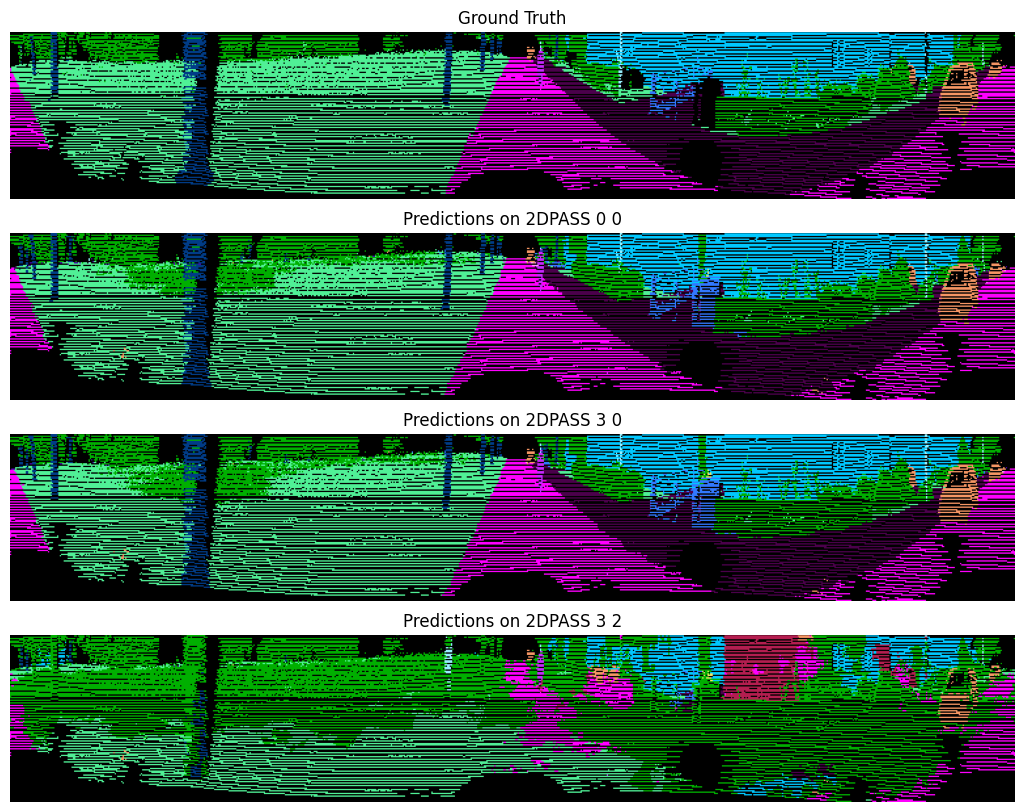

In [154]:
ttls = [  'Ground Truth'
        , 'Predictions on 2DPASS 0 0'
        , 'Predictions on 2DPASS 3 0'
        , 'Predictions on 2DPASS 3 2'
        ]
fig, axes = plt.subplots(4,1,figsize=(20,10))  
for i in range(4):
    axes[i].imshow(img_list2[i])
    axes[i].title.set_text(ttls[i])
    axes[i].axis('off')

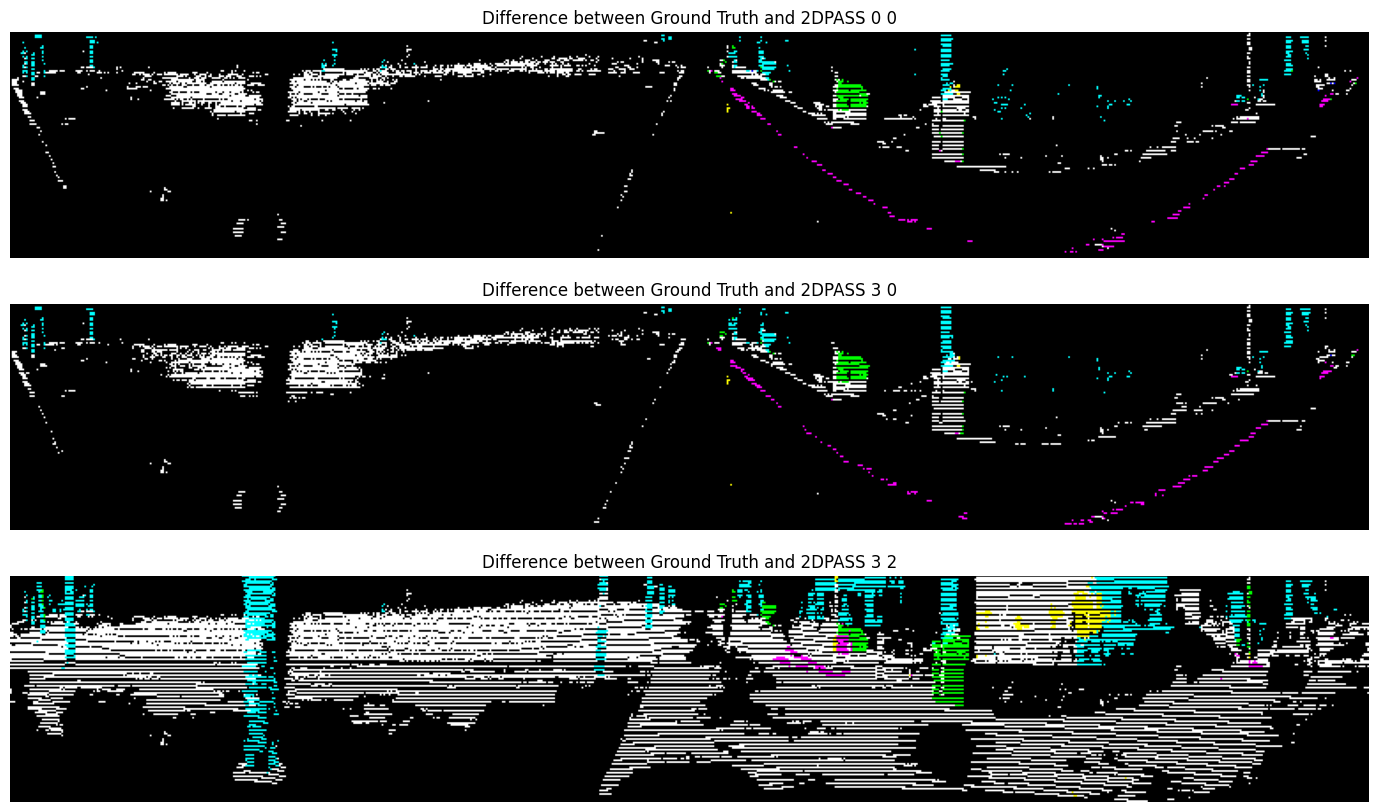

In [159]:
ttls = [  'Difference between Ground Truth and 2DPASS 0 0'
        , 'Difference between Ground Truth and 2DPASS 3 0'
        , 'Difference between Ground Truth and 2DPASS 3 2'
        ]
fig, axes = plt.subplots(3,1,figsize=(20,10))  
for i in range(0,3):
    axes[i].imshow((img_list2[0]!=img_list2[i+1]).astype(float))
    axes[i].title.set_text(ttls[i])
    axes[i].axis('off')

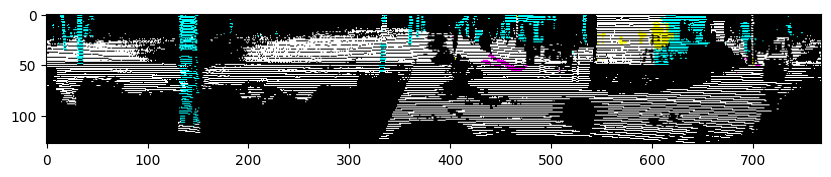

In [143]:

plt.figure(figsize=(10,10))
plt.imshow((img_list2[2]!=img_list2[3]).astype(float))

80.05665
79.9765
-0.24566928 -0.24562326


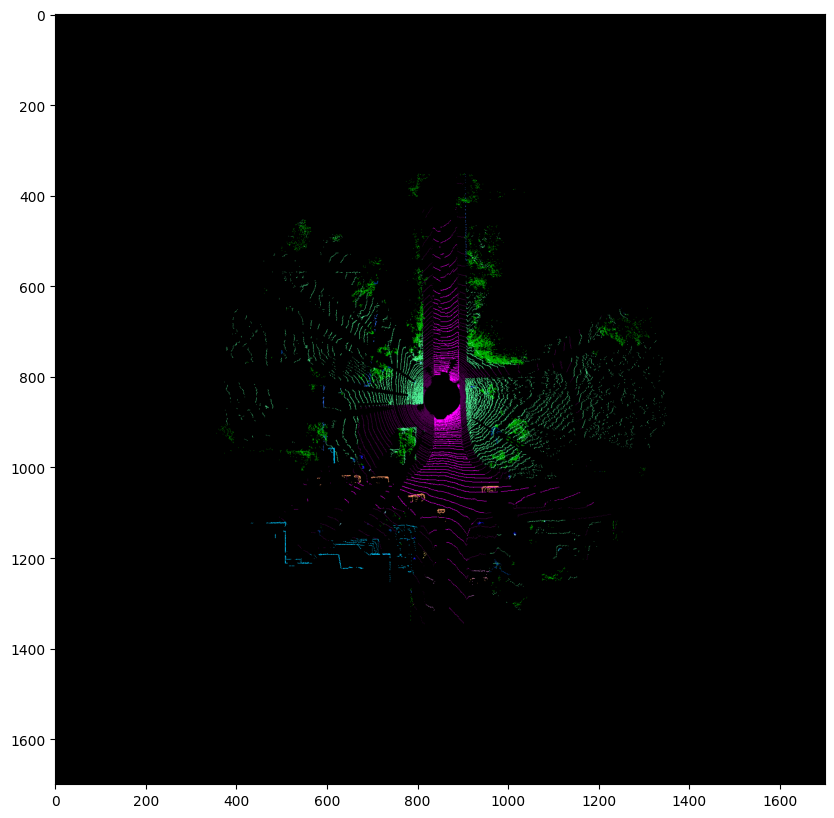

In [12]:
def show_one_scan(pc, poses, idx,dd):
    old_points = pc.points.copy()
    lbls = pc.sem_label_color.copy()
    # new_points = transform_cloud_to_origin_frame(pc.points.copy(), poses[:,idx * 4: (idx + 1) * 4])
    new_points = pc.points.copy()
    depth = np.linalg.norm(new_points, 2, axis=1)
    mask = (depth < 80.0) & (depth > 4)
    mask = np.random.choice(np.where(mask)[0],depth[mask].shape[0]//30,replace=False, p=freqs[0][np.floor(depth[mask]).astype('int')//8]/freqs[0][np.floor(depth[mask]).astype('int')//8].sum())
    
    # lbls = lbls[mask]
    # new_points = new_points[mask]
    new_points = np.vstack([new_points[mask],dd.points.copy()])
    lbls = np.vstack([lbls[mask],dd.sem_label_color])
    # pc.points = new_points
    # pc.do_range_projection()
    # fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(20,10))
    fig, (ax3) = plt.subplots(1,1,figsize=(20,10))
    # ax1.imshow(pc.proj_range)
    # ax2.imshow(create_birds_eye_view(old_points, 0.5))
    ax3.imshow(create_birds_eye_view(new_points, lbls, 0.1, side_range=(-85, 85), fwd_range=(-85, 85)))
    print(old_points.mean(),new_points.mean())
    pc.points = old_points
    return pc
def show_one_scan2(pc, poses, idx):
    old_points = pc.points.copy()
    lbls = pc.sem_label_color.copy()
    # new_points = transform_cloud_to_world_frame(pc.points.copy(), poses[:,idx * 4: (idx + 1) * 4])
    new_points = pc.points.copy()
    depth = np.linalg.norm(new_points, 2, axis=1)
    print(max(depth))
    mask = (depth < 80.0) & (depth > 4)
    new_points = new_points[mask]
    depth = np.linalg.norm(new_points, 2, axis=1)
    print(max(depth))
    lbls = lbls[mask]
    # pc.points = new_points
    # pc.do_range_projection()
    # fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(20,10))
    fig, (ax3) = plt.subplots(1,1,figsize=(20,10))
    # ax1.imshow(pc.proj_range)
    # ax2.imshow(create_birds_eye_view(old_points, 0.5))
    ax3.imshow(create_birds_eye_view(new_points, lbls, 0.1, side_range=(-85, 85), fwd_range=(-85, 85)))
    print(old_points.mean(),new_points.mean())
    pc.points = old_points
    return pc
show_one_scan2(two_pc, poses, 0)

In [13]:
a = SemLaserScan(color_dict,H=64*2, W=1024*2, project=False)
seq_i=8
a.open_scan(os.path.join(sequences_dir,sequence_folders[seq_i],'whole_map_0_1000.bin'))
a.open_label(os.path.join(sequences_dir,sequence_folders[seq_i],'whole_map_0_1000.label'))
# a.colorize()                 
# a.show(voxel_size=None)

: 

475.10263
79.999985
100.49946 10.867099


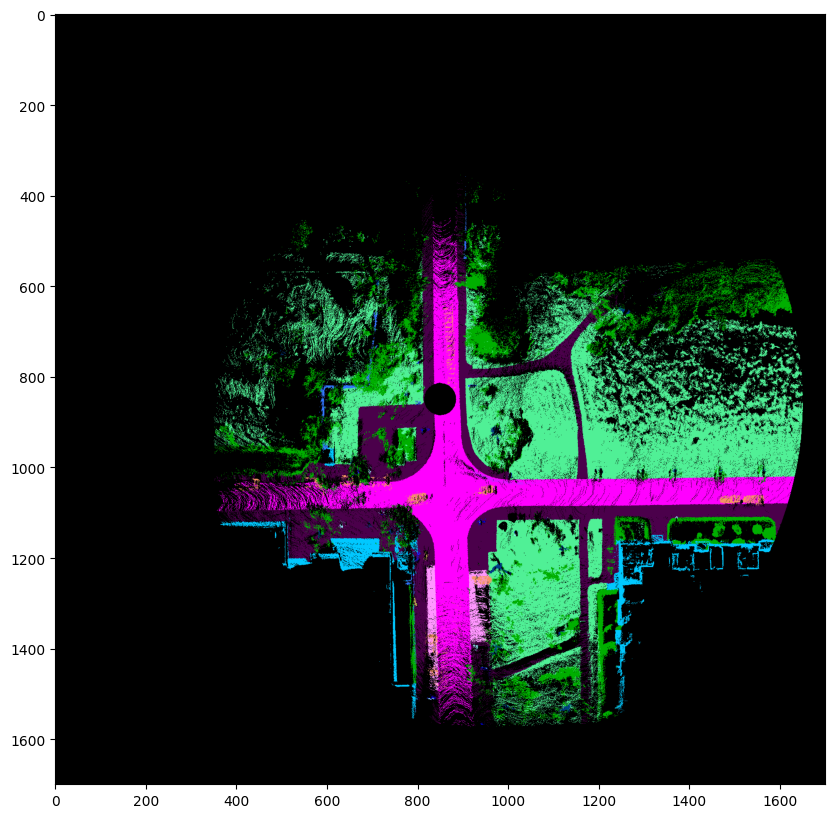

In [61]:
show_one_scan2(a, poses, 100)

100.49946 2.7881622


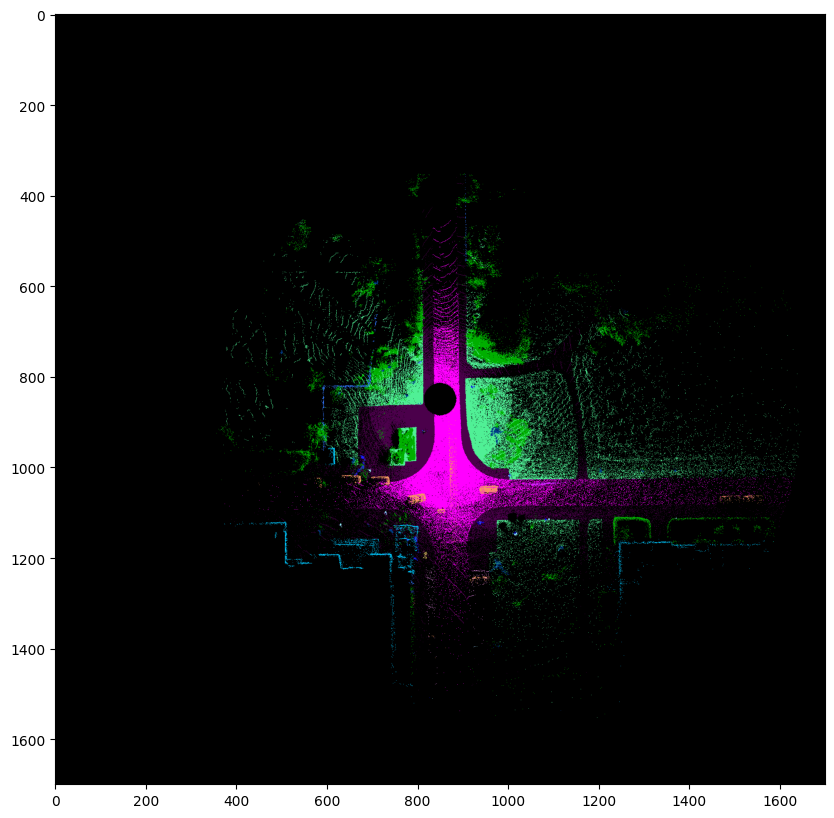

In [73]:
show_one_scan(a, poses, 0, one_pc)

matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


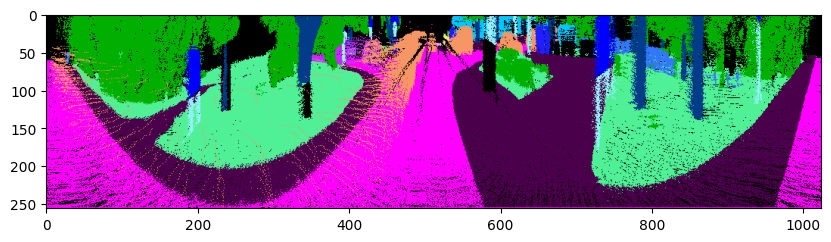

In [61]:
thr_pc = SemLaserScan(color_dict,H=256, W=512*2, project=True)

thr_pc.open_scan(os.path.join(sequences_dir,sequence_folders[seq_i],'whole_map_0_1000.bin'))
thr_pc.open_label(os.path.join(sequences_dir,sequence_folders[seq_i],'whole_map_0_1000.label'))
thr_pc.colorize()
# a.show()
thr_pc.proj_range.max(),thr_pc.proj_range[thr_pc.proj_range>0].min()

thr_pc.do_range_projection()
img = thr_pc.proj_sem_color.copy()
img[thr_pc.proj_range>50] = -1
plt.figure(figsize=(10,10))
plt.imshow(img)

100%|██████████| 1000/1000 [01:11<00:00, 14.07it/s]


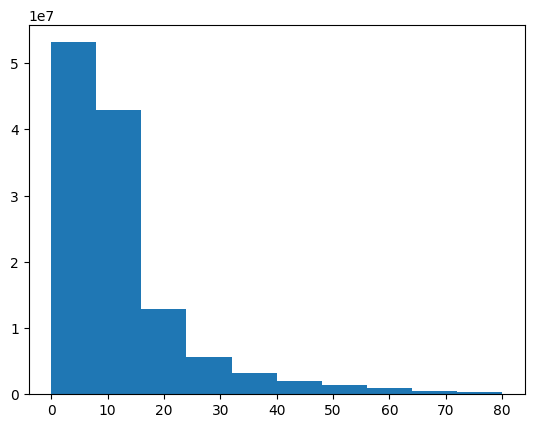

In [62]:

def build_kitti_map(base_path):

    # Load KITTI poses
    poses = parse_poses(os.path.join(base_path,"poses.txt"), parse_calibration(os.path.join(base_path,"calib.txt")))
    universal_scan = SemLaserScan(color_dict)
    all_points = []
    all_remissions = []
    all_labels = []
    for idx, pose in enumerate(tqdm(poses[0:1000])):
        scan_filename = os.path.join(base_path, "velodyne", f'{idx:06d}.bin')
        label_filename = os.path.join(base_path, "labels", f'{idx:06d}.label')
        
        if not os.path.isfile(scan_filename):
            continue
        universal_scan.open_scan(scan_filename)
        universal_scan.open_label(label_filename)
        
        # transformed_scan = transform_cloud_to_world_frame(universal_scan.points, pose)
        
        # if idx==0:
        #     all_points = universal_scan.points
        #     all_remissions = universal_scan.remissions
        #     all_labels = universal_scan.sem_label
        #     continue
        
        # new_points = transform_cloud_to_world_frame(universal_scan.points, pose)
        new_remissions = universal_scan.remissions
        new_labels = universal_scan.sem_label
        # all_points.append(new_points)
        all_points.append(universal_scan.points.copy())
        # all_remissions.append(new_remissions)
        # all_labels.append(new_labels)
        
    all_points = np.vstack(all_points)
    # all_remissions = np.hstack(all_remissions)
    # all_labels = np.hstack(all_labels)
    # universal_scan.set_points(all_points, all_remissions)
    # universal_scan.set_label(all_labels)

    return all_points

# set your KITTI point cloud directory and poses file
base_path = "/home/alex_odnakov/personal/dataset/sequences/08"

# build the global map
global_cloud_points = build_kitti_map(base_path)
freqs = plt.hist(np.floor(np.linalg.norm(global_cloud_points[:,:3], 2, axis=1)),bins=np.arange(0,81,8))
# visualize the global map
del global_cloud_points


In [7]:
xyz = a.points

for idx in tqdm(range(0,750)):
    scan_filename = os.path.join(base_path, "velodyne3", f'{idx:06d}.bin')
    orig_scan_filename = os.path.join(base_path, "velodyne", f'{idx:06d}.bin')
    orig_scan = np.fromfile(orig_scan_filename, dtype=np.float32).reshape((-1, 4))
    new_points = transform_cloud_to_origin_frame(xyz, poses[:,idx * 4: (idx + 1) * 4])
    depth = np.linalg.norm(new_points[:,:3], 2, axis=1)
    ind_filt = depth < 80
    # ind_filt2 = np.random.choice(np.where(ind_filt)[0],depth[ind_filt].shape[0]//30,replace=False, p=freqs[0][np.floor(depth[ind_filt]).astype('int')//8]/freqs[0][np.floor(depth[ind_filt]).astype('int')//8].sum())
    ind_filt2 = np.random.choice(np.where(ind_filt)[0],depth[ind_filt].shape[0]//30,replace=False)
    export = np.hstack([new_points[ind_filt2],a.remissions[ind_filt2].reshape((-1,1))])
    export = np.vstack([export,orig_scan]).reshape(-1).astype(np.float32)
    export.tofile(scan_filename)
    del export, new_points, ind_filt, ind_filt2, depth, orig_scan
    # break

100%|██████████| 100/100 [08:53<00:00,  5.33s/it]


: 

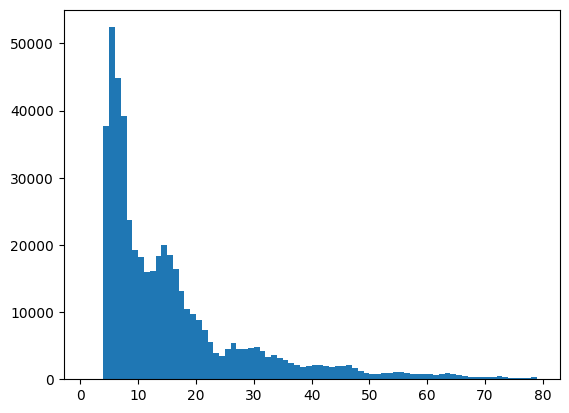

In [12]:

from pytorch_lightning.metrics import Metric

def get_SemKITTI_label_name(label_mapping):
    with open(label_mapping, 'r') as stream:
        semkittiyaml = yaml.safe_load(stream)
    SemKITTI_label_name = dict()
    for i in sorted(list(semkittiyaml['learning_map'].keys()))[::-1]:
        SemKITTI_label_name[semkittiyaml['learning_map'][i]] = semkittiyaml['labels'][i]

    return SemKITTI_label_name

def fast_hist(pred, label, n):
    k = (label >= 0) & (label < n)
    bin_count = np.bincount(
        n * label[k].astype(int) + pred[k], minlength=n ** 2)
    return bin_count[:n ** 2].reshape(n, n)

def per_class_iu(hist):
    return np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))

def fast_hist_crop(output, target, unique_label):
    hist = fast_hist(output.flatten(), target.flatten(), np.max(unique_label) + 2)
    hist = hist[unique_label + 1, :]
    hist = hist[:, unique_label + 1]
    return hist

class IoU(Metric):
    def __init__(self, dist_sync_on_step=False, compute_on_step=True):
        super().__init__(dist_sync_on_step=dist_sync_on_step, compute_on_step=compute_on_step)
        self.hist_list = []
        self.best_miou = 0
        self.SemKITTI_label_name = get_SemKITTI_label_name('/home/alex_odnakov/personal/gits/Codes-for-PVKD/config/label_mapping/semantic-kitti-all.yaml')
        self.unique_label = np.asarray(sorted(list(self.SemKITTI_label_name.keys())))[1:] - 1
        self.unique_label_str = [self.SemKITTI_label_name[x] for x in self.unique_label + 1]

    def update(self, predict_labels, val_pt_labs) -> None:
        self.hist_list.append(fast_hist_crop(predict_labels, val_pt_labs, self.unique_label))

    def compute(self):
        iou = per_class_iu(sum(self.hist_list))
        if np.nanmean(iou) > self.best_miou:
            self.best_miou = np.nanmean(iou)
        self.hist_list = []
        return iou, self.best_miou

In [32]:
val_iou = IoU()
scores = []
for idx in tqdm(range(0,4000)):
    true_label_filename = os.path.join('/home/alex_odnakov/personal/dataset/sequences/08', "labels", f'{idx:06d}.label')
    pred_label_filename = os.path.join('/home/alex_odnakov/personal/gits/Codes-for-PVKD/out_cyl/test/sequences/08', "predictions", f'{idx:06d}.label')
    true_label = np.fromfile(true_label_filename, dtype=np.uint32).reshape((-1))
    pred_label = (np.fromfile(pred_label_filename, dtype=np.uint32).reshape((-1)))
    val_iou.update(true_label, pred_label)
    # break

  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [00:19<00:00, 208.79it/s]


In [28]:
pred_label

array([15, 15, 15, ..., 15, 15, 15], dtype=uint32)

In [35]:
idx=100
np.unique(np.fromfile(os.path.join('/home/alex_odnakov/personal/gits/Codes-for-PVKD/out_cyl/test_converted/sequences/08', "predictions", f'{idx:06d}.label'), dtype=np.uint32).reshape((-1)),return_counts=True)

(array([15], dtype=uint32), array([124479]))

: 

In [33]:
iou, best_miou = val_iou.compute()
mIoU = np.nanmean(iou)
str_print = ''
print('val/mIoU', mIoU)
print('val/best_miou', best_miou)
str_print += 'Validation per class iou: '

for class_name, class_iou in zip(val_iou.unique_label_str, iou):
    str_print += '\n%s : %.2f%%' % (class_name, class_iou * 100)

str_print += '\nCurrent val miou is %.3f while the best val miou is %.3f' % (mIoU * 100, best_miou * 100)
print(str_print)

val/mIoU 3.554224959720427e-08
val/best_miou 3.554224959720427e-08
Validation per class iou: 
car : 0.00%
bicycle : 0.00%
motorcycle : 0.00%
truck : 0.00%
bus : 0.00%
person : 0.00%
bicyclist : nan%
motorcyclist : 0.00%
road : nan%
parking : 0.00%
sidewalk : 0.00%
other-ground : 0.00%
building : nan%
fence : 0.00%
vegetation : 0.00%
trunk : nan%
terrain : nan%
pole : 0.00%
traffic-sign : 0.00%
moving-car : 0.00%
moving-bicyclist : 0.00%
moving-person : 0.00%
moving-motorcyclist : 0.00%
moving-on-rails : 0.00%
moving-truck : 0.00%
Current val miou is 0.000 while the best val miou is 0.000


/tmp/ipykernel_23322/2873519198.py:19: RuntimeWarning: invalid value encountered in divide
  return np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))


In [242]:
classes = [
     'mIoU'
    , 'car'
    , 'bicycle'
    , 'motorcycle'
    , 'truck'
    , 'bus'
    , 'person'
    , 'bicyclist'
    , 'motorcyclist'
    , 'road'
    , 'parking'
    , 'sidewalk'
    , 'other'
    , 'building'
    , 'fence'
    , 'vegetation'
    , 'trunk'
    , 'terrain'
    , 'pole'
    , 'traffic-sign'
]
base2v =[
      '59.91%'
    , '97.43%'
    ,'50.53%'
    ,'28.81%'
    ,'0.00%'
    ,'85.81%'
    ,'70.43%'
    ,'93.58%'
    ,'0.00%'
    ,'96.00%'
    ,'31.57%'
    ,'88.71%'
    ,'1.57%'
    ,'91.91%'
    ,'39.37%'
    ,'84.03%'
    ,'80.39%'
    ,'82.55%'
    ,'62.73%'
    ,'53.02%'
]
base = [
      '58.00%'
    , '96.57%'
    , '48.86%'
    , '16.97%'
    , '0.00%'
    , '80.61%'
    , '67.27%'
    , '93.35%'
    , '0.00%'
    , '95.57%'
    , '24.15%'
    , '87.75%'
    , '1.79%'
    , '91.60%'
    , '37.48%'
    , '83.49%'
    , '79.94%'
    , '81.99%'
    , '62.13%'
    , '52.49%'
]
base2vmy = [
      '46.82%'
    , '86.97%'
    , '54.30%'
    , '54.18%'
    , '0.00%'
    , '48.29%'
    , '74.32%'
    , '91.42%'
    , '0.00%'
    , '85.11%'
    , '6.82%'
    , '34.95%'
    , '0.42%'
    , '67.29%'
    , '24.46%'
    , '51.25%'
    , '53.58%'
    , '52.73%'
    , '54.02%'
    , '49.51%'
]
base3v = [
      '59.81%'
    , '96.59%'
    , '51.12%'
    , '28.13%'
    , '0.00%'
    , '79.16%'
    , '71.07%'
    , '93.61%'
    , '0.00%'
    , '96.18%'
    , '34.05%'
    , '89.04%'
    , '1.68%'
    , '92.04%'
    , '39.42%'
    , '84.29%'
    , '80.90%'
    , '82.85%'
    , '63.14%'
    , '53.19%'
]
base3vmy = [
      '55.40%'
    , '93.78%'
    , '54.74%'
    , '34.38%'
    , '0.00%'
    , '75.33%'
    , '76.22%'
    , '93.51%'
    , '0.00%'
    , '92.15%'
    , '24.58%'
    , '76.19%'
    , '0.64'
    , '78.67%'
    , '32.17%'
    , '67.14%'
    , '72.05%'
    , '69.09%'
    , '59.08%'
    , '52.91%'
]

data = [
    base
    , base2v
    , base2vmy
    , base3v
    , base3vmy
]
# pd.DataFrame(data, columns=classes)
print(pd.DataFrame(data, columns=classes).to_latex())

\begin{tabular}{lllllllllllllllllllll}
\toprule
{} &    mIoU &     car & bicycle & motorcycle &  truck &     bus &  person & bicyclist & motorcyclist &    road & parking & sidewalk &  other & building &   fence & vegetation &   trunk & terrain &    pole & traffic-sign \\
\midrule
0 &  58.00\% &  96.57\% &  48.86\% &     16.97\% &  0.00\% &  80.61\% &  67.27\% &    93.35\% &        0.00\% &  95.57\% &  24.15\% &   87.75\% &  1.79\% &   91.60\% &  37.48\% &     83.49\% &  79.94\% &  81.99\% &  62.13\% &       52.49\% \\
1 &  59.91\% &  97.43\% &  50.53\% &     28.81\% &  0.00\% &  85.81\% &  70.43\% &    93.58\% &        0.00\% &  96.00\% &  31.57\% &   88.71\% &  1.57\% &   91.91\% &  39.37\% &     84.03\% &  80.39\% &  82.55\% &  62.73\% &       53.02\% \\
2 &  46.82\% &  86.97\% &  54.30\% &     54.18\% &  0.00\% &  48.29\% &  74.32\% &    91.42\% &        0.00\% &  85.11\% &   6.82\% &   34.95\% &  0.42\% &   67.29\% &  24.46\% &     51.25\% &  53.58\% &  52.73\% &  54.02\% &       4

/tmp/ipykernel_773733/2620336416.py:142: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(data, columns=classes).to_latex())


In [ ]:
\begin{tabular}{lllllllllllllllllllll}
\toprule
{} &    mIoU &     car & bicycle & motorcycle &  truck &     bus &  person & bicyclist & motorcyclist &    road & parking & sidewalk &  other & building &   fence & vegetation &   trunk & terrain &    pole & traffic-sign \\
\midrule
0 &  58.00\% &  96.57\% &  48.86\% &     16.97\% &  0.00\% &  80.61\% &  67.27\% &    93.35\% &        0.00\% &  95.57\% &  24.15\% &   87.75\% &  1.79\% &   91.60\% &  37.48\% &     83.49\% &  79.94\% &  81.99\% &  62.13\% &       52.49\% \\
1 &  59.91\% &  97.43\% &  50.53\% &     28.81\% &  0.00\% &  85.81\% &  70.43\% &    93.58\% &        0.00\% &  96.00\% &  31.57\% &   88.71\% &  1.57\% &   91.91\% &  39.37\% &     84.03\% &  80.39\% &  82.55\% &  62.73\% &       53.02\% \\
2 &  46.82\% &  86.97\% &  54.30\% &     54.18\% &  0.00\% &  48.29\% &  74.32\% &    91.42\% &        0.00\% &  85.11\% &   6.82\% &   34.95\% &  0.42\% &   67.29\% &  24.46\% &     51.25\% &  53.58\% &  52.73\% &  54.02\% &       49.51\% \\
3 &  59.81\% &  96.59\% &  51.12\% &     28.13\% &  0.00\% &  79.16\% &  71.07\% &    93.61\% &        0.00\% &  96.18\% &  34.05\% &   89.04\% &  1.68\% &   92.04\% &  39.42\% &     84.29\% &  80.90\% &  82.85\% &  63.14\% &       53.19\% \\
4 &  55.40\% &  93.78\% &  54.74\% &     34.38\% &  0.00\% &  75.33\% &  76.22\% &    93.51\% &        0.00\% &  92.15\% &  24.58\% &   76.19\% &   0.64 &   78.67\% &  32.17\% &     67.14\% &  72.05\% &  69.09\% &  59.08\% &       52.91\% \\
\bottomrule
\end{tabular}